In [44]:
import pandas as pd
import sqlite3
import seaborn as sns

In [45]:
con = sqlite3.connect('../Data/im.db')
cursor=con.cursor()

In [46]:
%%script sqlite3 ../Data/im.db --out tables
.tables
.quit

In [47]:
master_sql = pd.read_sql('''
SELECT primary_title, start_year, runtime_minutes, genres, averagerating, primary_name, category
FROM principals
JOIN persons
    USING(person_id)
JOIN movie_basics
    USING(movie_id)
JOIN movie_ratings
    USING(movie_id)
WHERE start_year > 2011
AND numvotes > 1000
''', con)

master_sql

,primary_title,start_year,runtime_minutes,genres,averagerating,primary_name,category
0,The Other Side of the Wind,2018,122.0,Drama,6.9,Orson Welles,director
1,The Other Side of the Wind,2018,122.0,Drama,6.9,Peter Bogdanovich,actor
2,The Other Side of the Wind,2018,122.0,Drama,6.9,John Huston,actor
3,The Other Side of the Wind,2018,122.0,Drama,6.9,Susan Strasberg,actress
4,The Other Side of the Wind,2018,122.0,Drama,6.9,Gary Graver,cinematographer
...,...,...,...,...,...,...,...
75590,The Hard Way,2019,92.0,Action,4.7,Michael Jai White,actor
75591,The Hard Way,2019,92.0,Action,4.7,Thomas J. Churchill,writer
75592,The Hard Way,2019,92.0,Action,4.7,Randy Couture,actor
75593,The Hard Way,2019,92.0,Action,4.7,Madalina Anea,actress


In [48]:
genre_explore = master_sql.copy()
genre_explore['genres'].value_counts().head(20)

Drama                         5804
Comedy                        4369
Comedy,Drama                  3605
Drama,Romance                 2575
Comedy,Drama,Romance          2342
Documentary                   2248
Comedy,Romance                1828
Horror,Thriller               1725
Action,Crime,Drama            1484
Horror                        1428
Drama,Thriller                1404
Crime,Drama,Thriller          1245
Action,Thriller               1106
Action,Crime,Thriller         1003
Adventure,Animation,Comedy     984
Horror,Mystery,Thriller        948
Action,Drama                   826
Action,Adventure,Comedy        816
Thriller                       803
Biography,Drama                794
Name: genres, dtype: int64

In [49]:
budget_info = pd.read_csv('../Data/tn.movie_budgets.csv.gz')
budget_info

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"
...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,"$7,000",$0,$0
5778,79,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495"
5779,80,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338"
5780,81,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0


In [50]:
relevant_budget_info = budget_info.copy()
relevant_budget_info.rename(columns = {'movie':'primary_title'}, inplace = True)
relevant_budget_info = relevant_budget_info[['primary_title', 'production_budget', 'worldwide_gross']]

In [51]:
joined_df = pd.merge(master_sql, relevant_budget_info, on=['primary_title'])
joined_df['primary_title'].value_counts()

Legend                   40
The Gambler              40
The Square               40
Beauty and the Beast     40
Life                     40
                         ..
Inside Llewyn Davis       9
Crowsnest                 8
Under the Rainbow         8
Indie Game: The Movie     7
Hawaii                    7
Name: primary_title, Length: 1269, dtype: int64

In [52]:
joined_df['production_budget'] = joined_df['production_budget'].str.replace(',', '').str.replace('$', '').astype(int)
joined_df['worldwide_gross'] = joined_df['worldwide_gross'].str.replace(',', '').str.replace('$', '').astype(int)
joined_df['profit'] = joined_df['worldwide_gross'] - joined_df['production_budget']


In [53]:
joined_df2 = joined_df.sort_values(by='profit', ascending=False)
joined_df2

,primary_title,start_year,runtime_minutes,genres,averagerating,primary_name,category,production_budget,worldwide_gross,profit
11204,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",8.5,Stephen McFeely,writer,300000000,2048134200,1748134200
11200,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",8.5,Anthony Russo,director,300000000,2048134200,1748134200
11195,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",8.5,Robert Downey Jr.,actor,300000000,2048134200,1748134200
11196,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",8.5,Chris Evans,actor,300000000,2048134200,1748134200
11197,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",8.5,Jack Kirby,writer,300000000,2048134200,1748134200
...,...,...,...,...,...,...,...,...,...,...
13056,Dark Phoenix,2019,113.0,"Action,Adventure,Sci-Fi",6.0,Stan Lee,writer,350000000,149762350,-200237650
13057,Dark Phoenix,2019,113.0,"Action,Adventure,Sci-Fi",6.0,James McAvoy,actor,350000000,149762350,-200237650
13058,Dark Phoenix,2019,113.0,"Action,Adventure,Sci-Fi",6.0,Michael Fassbender,actor,350000000,149762350,-200237650
13059,Dark Phoenix,2019,113.0,"Action,Adventure,Sci-Fi",6.0,Chris Claremont,writer,350000000,149762350,-200237650


## Remove animation code (Currently unused)

In [54]:
#No animation code

# no_anim_df = joined_df2.copy()
# no_anim_df = no_anim_df[~no_anim_df.genres.str.contains("Animation")]
# #Filter out 0 values
# no_anim_df


## Remove Talent with only 1 or 2 projects

In [55]:
filtered_df2 = joined_df2.copy()
counts = filtered_df2['primary_name'].value_counts()
filtered_df3 = filtered_df2[filtered_df2['primary_name'].isin(counts.index[counts > 2])]
filtered_df3

,primary_title,start_year,runtime_minutes,genres,averagerating,primary_name,category,production_budget,worldwide_gross,profit
11204,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",8.5,Stephen McFeely,writer,300000000,2048134200,1748134200
11200,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",8.5,Anthony Russo,director,300000000,2048134200,1748134200
11195,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",8.5,Robert Downey Jr.,actor,300000000,2048134200,1748134200
11196,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",8.5,Chris Evans,actor,300000000,2048134200,1748134200
11197,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",8.5,Jack Kirby,writer,300000000,2048134200,1748134200
...,...,...,...,...,...,...,...,...,...,...
13054,Dark Phoenix,2019,113.0,"Action,Adventure,Sci-Fi",6.0,Nicholas Hoult,actor,350000000,149762350,-200237650
13055,Dark Phoenix,2019,113.0,"Action,Adventure,Sci-Fi",6.0,Jack Kirby,writer,350000000,149762350,-200237650
13056,Dark Phoenix,2019,113.0,"Action,Adventure,Sci-Fi",6.0,Stan Lee,writer,350000000,149762350,-200237650
13057,Dark Phoenix,2019,113.0,"Action,Adventure,Sci-Fi",6.0,James McAvoy,actor,350000000,149762350,-200237650


## Most Profitable Actors and Actresses

In [107]:
actor_analysis = filtered_df3.copy()
actor_analysis = actor_analysis[actor_analysis['category'].isin(['actor', 'actress'])]
actor_analysis = actor_analysis[['primary_name', 'profit']]
actor_analysis['profit'] = (actor_analysis['profit'] / 1000000).round(0)
actor_analysis = actor_analysis.groupby('primary_name', as_index=False)['profit'].median()
actor_analysis = actor_analysis.sort_values(by='profit', ascending=False)

In [108]:
actor_analysis.head(10)

,primary_name,profit
80,Bryce Dallas Howard,1136.0
452,Pierre Coffin,1086.0
473,Robert Downey Jr.,952.5
214,Ian McKellen,703.0
467,Richard Armitage,703.0
59,Benjamin Bratt,623.0
514,Stanley Tucci,598.0
363,Léa Seydoux,588.0
129,Daniel Craig,580.0
34,Andy Serkis,541.0


[Text(0, 0.5, '')]

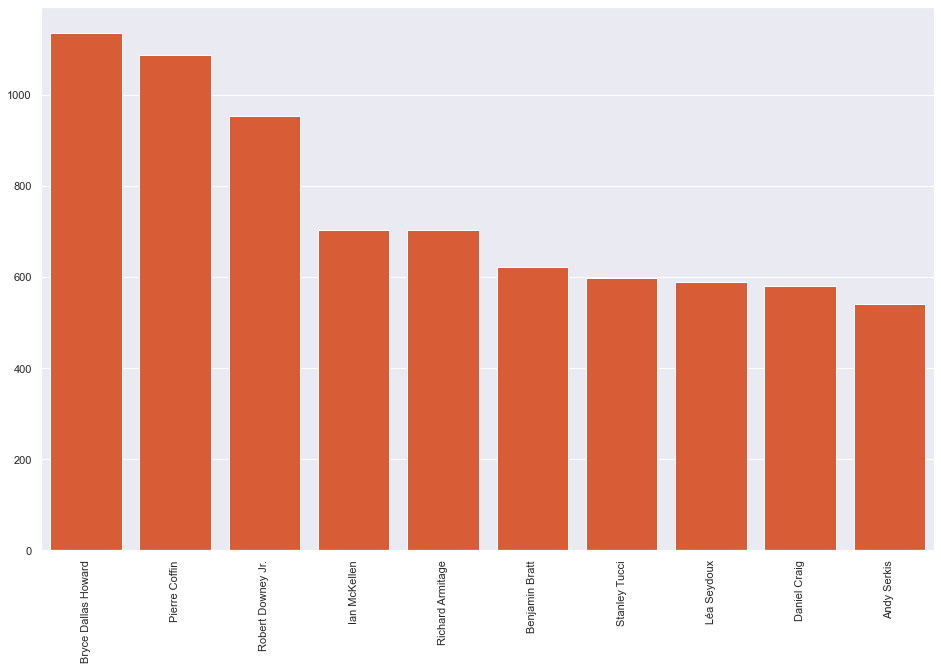

In [125]:
top_actor_analysis = actor_analysis.head(10)
sns.set(rc={'figure.figsize':(16,10)})
ax = sns.barplot(x='primary_name', y='profit', data=top_actor_analysis, color='#F34F1C')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.ticklabel_format(style='plain', axis='y')
ax.set(xlabel=None)
ax.set(ylabel=None)

## Most Profitable Directors

In [110]:
director_analysis = filtered_df3.copy()
director_analysis = director_analysis[director_analysis['category'] == 'director']
director_analysis = director_analysis[['primary_name', 'profit']]
director_analysis['profit'] = (director_analysis['profit'] / 1000000).round(0)
director_analysis = director_analysis.groupby('primary_name', as_index=False)['profit'].median()
director_analysis = director_analysis.sort_values(by='profit', ascending=False)

In [111]:
director_analysis.head(10)

,primary_name,profit
80,Jennifer Lee,1122.0
76,James Wan,987.0
128,Pierre Coffin,929.5
6,Anthony Russo,890.0
82,Joe Russo,890.0
21,Chris Renaud,812.0
28,Colin Trevorrow,719.0
125,Peter Jackson,710.0
12,Bill Condon,588.0
57,Francis Lawrence,565.5


[Text(0, 0.5, '')]

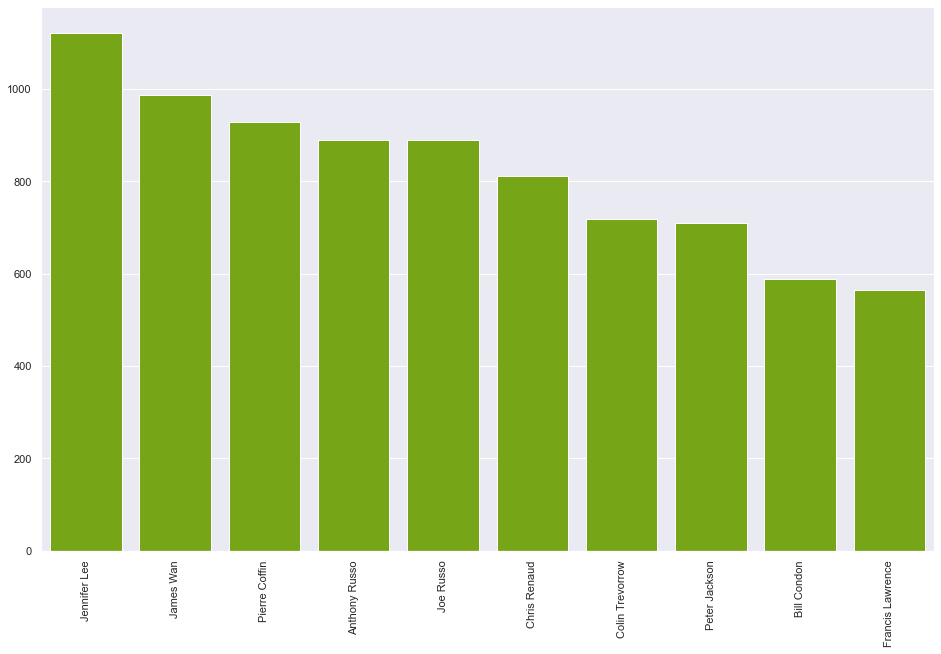

In [124]:
top_director_analysis = director_analysis.head(10)
sns.set(rc={'figure.figsize':(16,10)})
ax = sns.barplot(x='primary_name', y='profit', data=top_director_analysis, color='#7FBC00')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.ticklabel_format(style='plain', axis='y')
ax.set(xlabel=None)
ax.set(ylabel=None)

## Most Profitable Writers

In [113]:
writer_analysis = filtered_df3.copy()
writer_analysis = writer_analysis[writer_analysis['category'] == 'writer']
writer_analysis = writer_analysis[['primary_name', 'profit']]
writer_analysis['profit'] = (writer_analysis['profit'] / 1000000).round(0)
writer_analysis = writer_analysis.groupby('primary_name', as_index=False)['profit'].median()
writer_analysis = writer_analysis.sort_values(by='profit', ascending=False)

In [114]:
writer_analysis.head(10)

,primary_name,profit
38,Colin Trevorrow,1136.0
141,Ken Daurio,899.0
37,Cinco Paul,899.0
109,Joe Simon,890.0
214,Stephen Chbosky,843.5
100,Jeanne-Marie Leprince de Beaumont,843.5
19,Brian Lynch,812.0
206,Scott Rosenberg,738.0
91,J.R.R. Tolkien,710.0
85,Guillermo del Toro,710.0


[Text(0, 0.5, '')]

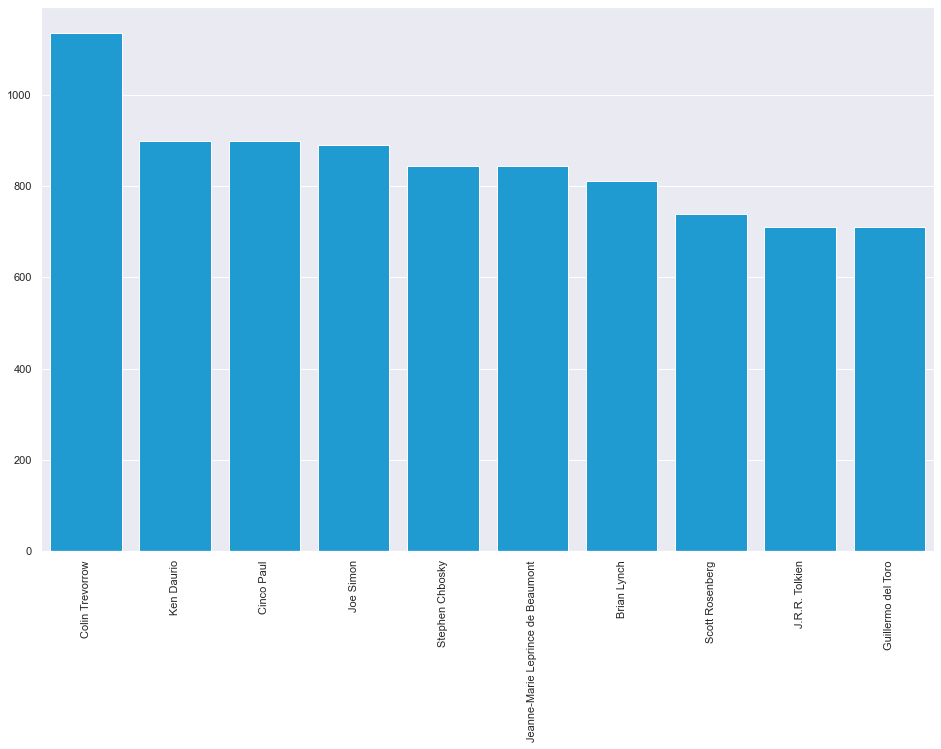

In [123]:
top_writer_analysis = writer_analysis.head(10)
sns.set(rc={'figure.figsize':(16,10)})
ax = sns.barplot(x='primary_name', y='profit', data=top_writer_analysis, color='#01A6F0')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.ticklabel_format(style='plain', axis='y')
ax.set(xlabel=None)
ax.set(ylabel=None)